In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Load and prepare data
data = pd.read_csv('data.csv')

# Reshape data
monthly_data = pd.melt(data, id_vars=['ITEM DESCRIPTION'],
                       value_vars=[col for col in data.columns if 'JANUARY' in col or 'FEBRUARY' in col or 'MARCH' in col or 'APRIL' in col or 'MAY' in col or 'JUNE' in col or 'JULY' in col or 'AUGUST' in col or 'SEPTEMBER' in col or 'OCTOBER' in col or 'NOVEMBER' in col or 'DECEMBER' in col],
                       var_name='Month_Year', value_name='Consumption')

# Extract year and month
monthly_data['Year'] = monthly_data['Month_Year'].str.split('_').str[1]
monthly_data['Month'] = monthly_data['Month_Year'].str.split('_').str[0]

# Create a date column
monthly_data['Date'] = pd.to_datetime(monthly_data['Month'] + ' ' + monthly_data['Year'], format='%B %Y')

# Drop unnecessary columns
monthly_data = monthly_data.drop(columns=['Month_Year'])

# Sort by date
monthly_data = monthly_data.sort_values(by='Date')

# Set Date as index
monthly_data.set_index('Date', inplace=True)
monthly_data.head()


,ITEM DESCRIPTION,Consumption,Year,Month
Date,,,,
2019-01-01,18 - Reactive Protein (CRP) - 300t - Dt Slides...,4,2019,JANUARY
2019-01-01,Ringer Lactate - Compound Sodium Lactate Injec...,119,2019,JANUARY
2019-01-01,Ring File 79,33,2019,JANUARY
2019-01-01,Ribbon Gauze Non-Sterile (VAGINAL Pack) 5m x 5...,6,2019,JANUARY
2019-01-01,Ribbon Gauze Non-Sterile (ENT Pack) 5m x 1.25c...,0,2019,JANUARY


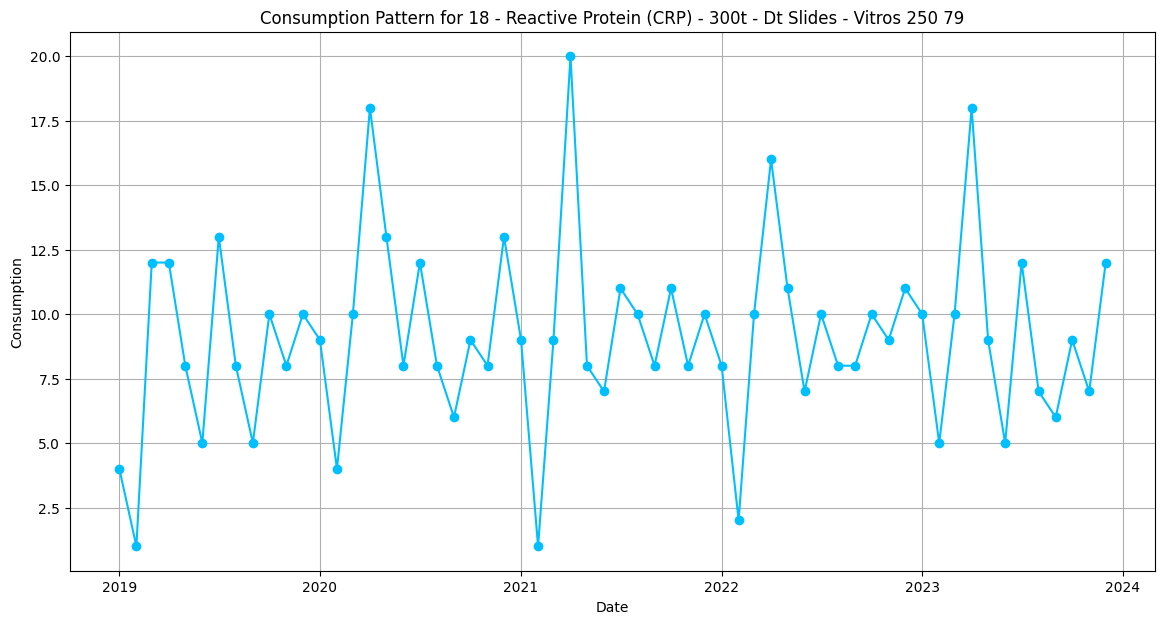

In [10]:
# Plot consumption patterns for a sample item
sample_item = monthly_data['ITEM DESCRIPTION'].unique()[0]
sample_data = monthly_data[monthly_data['ITEM DESCRIPTION'] == sample_item]

plt.figure(figsize=(14, 7))
plt.plot(sample_data.index, sample_data['Consumption'], marker='o', linestyle='-', color='deepskyblue')
plt.title(f'Consumption Pattern for {sample_item}')
plt.xlabel('Date')
plt.ylabel('Consumption')
plt.grid(True)
plt.show()


In [28]:
# Prepare for each item
items = monthly_data['ITEM DESCRIPTION'].unique()

future_predictions_all_items = []

for item in items:
    # Filter data for the current item
    item_data = monthly_data[monthly_data['ITEM DESCRIPTION'] == item].copy()

    # Prepare features and target
    item_data['Month'] = item_data.index.month
    item_data['Year'] = item_data.index.year
    item_data['Day_of_Week'] = item_data.index.dayofweek

    # Example target variable: Predict next month's consumption
    item_data['Next_Consumption'] = item_data['Consumption'].shift(-1)
    item_data = item_data.dropna()

    # Features and target
    X = item_data[['Month', 'Year', 'Day_of_Week']]
    y = item_data['Next_Consumption']

    # Split data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # Initialize Random Forest regressor
    model = RandomForestRegressor(n_estimators=100, random_state=42)

    # Train the model
    model.fit(X_train, y_train)

    # Evaluate the model
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f'Item: {item} - Mean Squared Error: {mse}')

    # Predict next month's consumption for the next 12 months
    future_dates = pd.date_range(start=item_data.index.max() + pd.DateOffset(months=1), periods=12, freq='MS')
    future_features = pd.DataFrame({
        'Month': future_dates.month,
        'Year': future_dates.year,
        'Day_of_Week': future_dates.dayofweek
    })

    # Predict future consumption
    future_predictions = model.predict(future_features)

    # Create DataFrame for future predictions
    future_df = pd.DataFrame({'Date': future_dates, 'Item': item, 'Predicted_Consumption': future_predictions})
    future_predictions_all_items.append(future_df)

# Combine all future predictions into a single DataFrame
final_predictions = pd.concat(future_predictions_all_items)
final_predictions.head()

# Save predictions to CSV
final_predictions.to_csv('future_predictions.csv', index=False)

Item: 18 - Reactive Protein (CRP) - 300t - Dt Slides - Vitros 250 79 - Mean Squared Error: 4.7343166666666665
Item: Ringer Lactate - Compound Sodium Lactate Injection Ip - 500ml 79 - Mean Squared Error: 2.1622249999999967
Item: Ring File 79 - Mean Squared Error: 2.459716666666666
Item: Ribbon Gauze Non-Sterile (VAGINAL Pack) 5m x 5cm 79 - Mean Squared Error: 1.1826583333333331
Item: Ribbon Gauze Non-Sterile (ENT Pack) 5m x 1.25cm 79 - Mean Squared Error: 2.7804083333333334
Item: Ribbon - Barcode Label Printer Ribbon Zebra Tlc Label Roll+Wax 79 - Mean Squared Error: 14.74305833333333
Item: RF Reagent Pack 79 - Mean Squared Error: 3.429458333333333
Item: Reservoir Bag - Infant 79 - Mean Squared Error: 1.3418583333333334
Item: Reservoir Bag - Child 79 - Mean Squared Error: 3.3245
Item: Reservoir Bag - Adult 79 - Mean Squared Error: 1.5490833333333331
Item: Referral Form (H-1) - A4 79 - Mean Squared Error: 1.57955
Item: Recordable Cd With Cover 79 - Mean Squared Error: 75.1979250000001
Ite

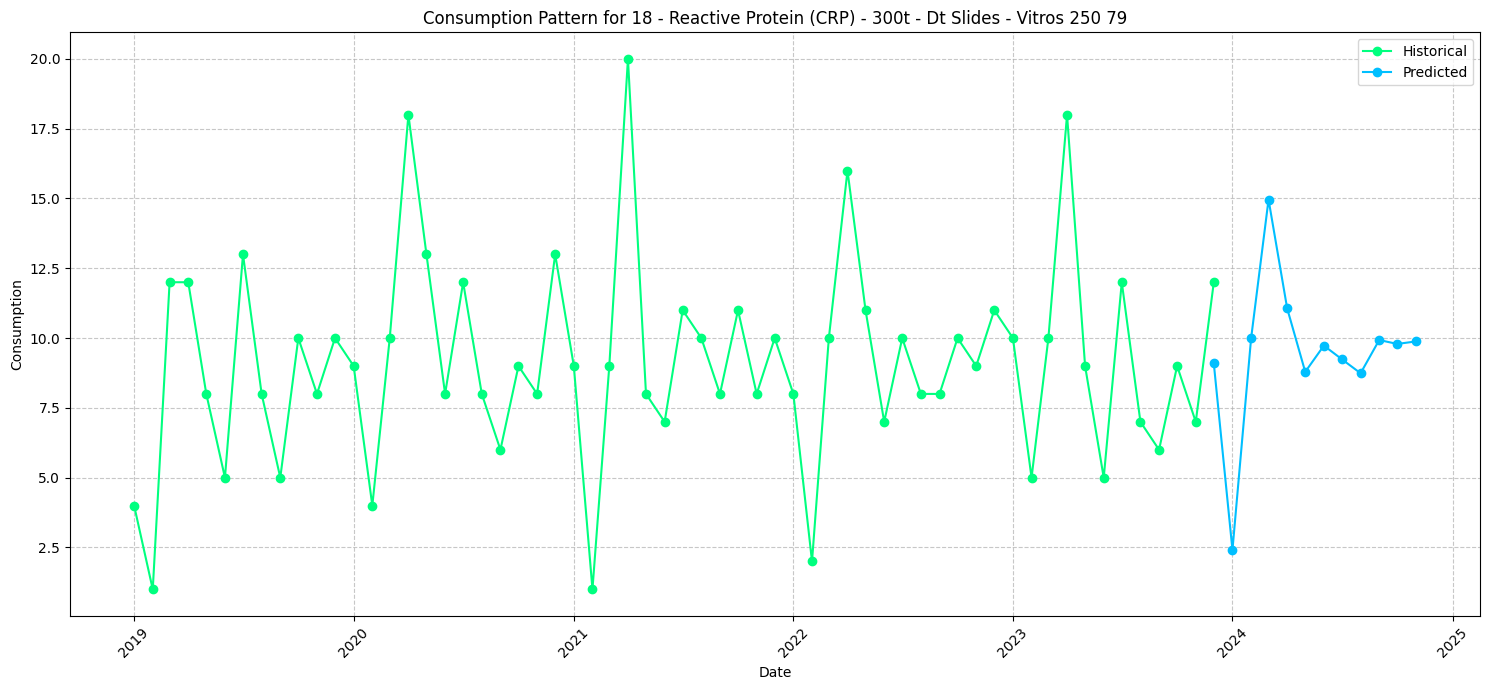

Plotting consumption for: 18 - Reactive Protein (CRP) - 300t - Dt Slides - Vitros 250 79
Historical data range: 2019-01-01 00:00:00 to 2023-12-01 00:00:00
Prediction range: 2023-12-01 00:00:00 to 2024-11-01 00:00:00


In [31]:
# Choose an item to plot (you can change this to any item in your dataset)
item_to_plot = items[0]  # This selects the first item in the list

# Filter data for the chosen item
historical_data = monthly_data[monthly_data['ITEM DESCRIPTION'] == item_to_plot]
predicted_data = final_predictions[final_predictions['Item'] == item_to_plot]

# Create the plot
plt.figure(figsize=(15, 7))

# Plot historical data
plt.plot(historical_data.index, historical_data['Consumption'], label='Historical', color='springgreen', marker='o')

# Plot predicted data
plt.plot(predicted_data['Date'], predicted_data['Predicted_Consumption'], label='Predicted', color='deepskyblue', marker='o')

# Add labels and title
plt.title(f'Consumption Pattern for {item_to_plot}')
plt.xlabel('Date')
plt.ylabel('Consumption')

# Add legend
plt.legend()

# Show grid
plt.grid(True, linestyle='--', alpha=0.7)


# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# Show the plot
plt.show()

# Print some information about the plot
print(f"Plotting consumption for: {item_to_plot}")
print(f"Historical data range: {historical_data.index.min()} to {historical_data.index.max()}")
print(f"Prediction range: {predicted_data['Date'].min()} to {predicted_data['Date'].max()}")